## Three stages of modeling 

We can divide the modeling problem into three stages, with each stage gradually considering more context.

+ Stage 1 - Consider every target independently
+ Stage 2 - Consider intra-`time_id` context information
+ Stage 3 - Consider inter-`time_id` context information

I shared about the model in Stage 2 and some thoughts in [PyTorch template + Transformer + Data Augmentation](https://www.kaggle.com/siahuat/pytorch-template-transformer-data-augmentation).

In this notebook, I will share my first try on Stage 3!

## Model structure

As in [PyTorch template + Transformer + Data Augmentation](https://www.kaggle.com/siahuat/pytorch-template-transformer-data-augmentation), I think we can learn to extract memory and recurrently feed it to the next time-step to gain more context information during prediction.

I found the same model structure design (b) in the paper [Memory transformer](https://arxiv.org/pdf/2006.11527.pdf), and with more exciting extensions (c, d).

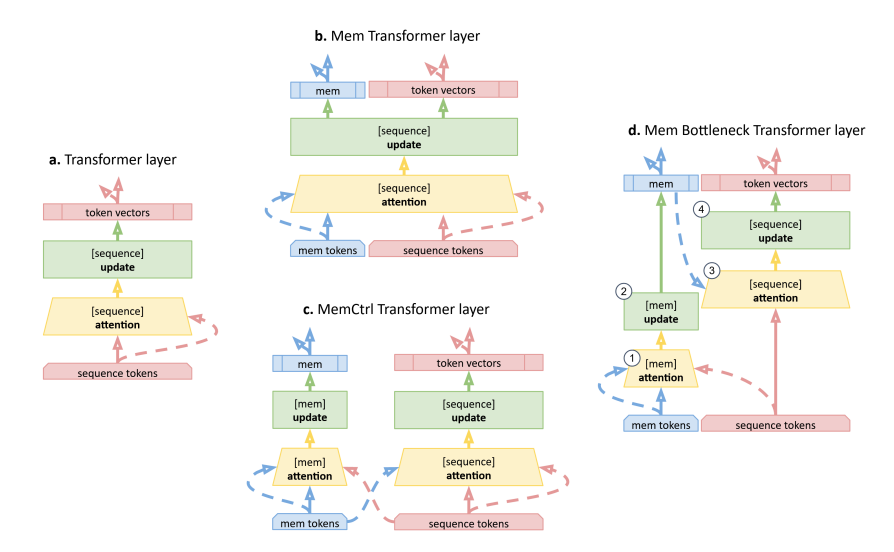


_Reference: Figure 1 of [Memory transformer](https://arxiv.org/pdf/2006.11527.pdf)_

> During the implementation, I was wondering, _does it really make sense for the model to learn to explicitly extract "memories" while it can actually "memoize" through the weights?_ And then I realized that it is not about just learning the past, but is an **efficient** way to (maybe) improve future predictions using recent data, without the need to fine-tune the model or attend to all the recent data. Of course, this is the ideal case, and I don't know if it works in the market prediction or this contest. I would appreciate it if you would like to share your experience or opinion!


## Other details

+ How to train
    + We should feed in a time-series of investments data for each update so that the model will learn to extract informational features for future predictions. The sequence can't be too long since we recurrently feed the memory pool to the next time-step, and we need to save all the graph information in memory (if there is no other trick).
    + In this notebook, we can set the time sequence length as the batch size.
+ CV vs. LB
    + I use the last 10% of the data for the validation.
    + Based on my recent submissions, the cv and lb are highly related now, but it may be that important as there is a [time gap between public and private lb](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/310602). 
+ Initialization of memory tokens
    + I use a sinusoidal positional encoding


## What's next

+ Visualize train loss through time per epoch
    + reweight loss per sample? (to prevent overfitting on easy samples)
+ Data augmentation on time-axis
    + sampling subsequence (time-axis, maybe drop 0~10% of the whole dataset) to train through per epoch?
+ Enhance the learning of memory pool?
    + design auxiliary task
        + for example, an auxiliary task that predicts the targets solely based on the previous memories (without current features)
        + we should expect this auxiliary task to work, at least outperforming the baseline of just predicting targets on investment_id. But if not, we still can't prove that memory is entirely useless because the model might still benefit from the interaction between current features and the previous memories.
    + try Mem bottleneck Transformer?

If you would like to run locally, look at this [GitHub repo](https://github.com/siahuat0727/ubiquant-market-prediction)! :)

## Talk is cheap. Here is the code.

In [ ]:
!pip install ../input/202202-libraries/torchmetrics-0.7.2-py3-none-any.whl --user

In [ ]:
import torchmetrics
assert torchmetrics.__version__ == '0.7.2', torchmetrics.__version__

import torch
print(torch.cuda.get_device_name(0))

## constants.py

In [ ]:
N_INVESTMENT = 3774
FEATURES = [f'f_{i}' for i in range(300)]

## utils.py

In [ ]:
import math

import torch


def rand_uniform(lo, hi):
    return torch.FloatTensor(1).uniform_(lo, hi).item()


# Modified from https://github.com/wzlxjtu/PositionalEncoding2D
def pos_encoding(length, n_dim, device='cpu', dtype=torch.float):
    """
    :param n_dim: dimension of the model
    :param length: length of positions
    :return: length*n_dim position matrix
    """
    if n_dim % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         f"odd dim (got n_dim={n_dim:d})")
    pe = torch.zeros(length, n_dim, device=device)
    position = torch.arange(length, dtype=dtype, device=device).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, n_dim, 2, device=device, dtype=dtype) *
                         -(math.log(10000.0) / n_dim)))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

## model.py

In [ ]:
import torch
from torch import nn
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertLayer as _BertLayer

# from utils import pos_encoding


class SafeEmbedding(nn.Embedding):
    "Handle unseen id"

    def forward(self, input):
        output = torch.empty((*input.size(), self.embedding_dim),
                             device=input.device,
                             dtype=self.weight.dtype)

        seen = input < self.num_embeddings
        unseen = seen.logical_not()

        output[seen] = super().forward(input[seen])
        output[unseen] = torch.zeros_like(
            self.weight[0]).expand(unseen.sum(), -1)
        return output


class FlattenBatchNorm1d(nn.BatchNorm1d):
    "BatchNorm1d that treats (N, C, L) as (N*C, L)"

    def forward(self, input):
        sz = input.size()
        return super().forward(input.view(-1, sz[-1])).view(*sz)


class BertLayer(_BertLayer):
    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs)[0]


class MemBertLayer(BertLayer):
    def __init__(self, *args, n_mem=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_mem = n_mem

    def forward(self, hidden, mem=None, **kwargs):
        # T x L x D, T is time dimension, L is length of investment per time
        assert hidden.dim() == 3, hidden.size()

        if mem is None:
            mem = pos_encoding(self.n_mem, hidden.size(2),
                               device=hidden.device,
                               dtype=hidden.dtype).unsqueeze(0)
        # If T = 1
        # hidden = torch.cat([mem, hidden], dim=1)
        # hidden = super().forward(hidden, **kwargs)
        # mem, hidden = hidden[:, :mem.size(1)], hidden[:, mem.size(1):]
        # return hidden, mem

        out_hidden = torch.Tensor().type_as(hidden)
        for cur_hidden in hidden:
            cur_hidden = torch.cat([mem, cur_hidden.unsqueeze(0)], dim=1)
            cur_hidden = super().forward(cur_hidden, **kwargs)
            mem = cur_hidden[:, :mem.size(1)]
            out_hidden = torch.cat([out_hidden, cur_hidden[:, mem.size(1):]])
        return out_hidden, mem


class BasicLayer(nn.Module):
    def __init__(self, args, in_sz, out_sz, mha=False):
        super().__init__()
        self.args = args

        layers = [
            nn.Linear(in_sz, out_sz),
            FlattenBatchNorm1d(out_sz),
            nn.SiLU(),
        ]
        if args.dropout > 0.0:
            layers.append(nn.Dropout(p=args.dropout))
        self.layers = nn.Sequential(*layers)

        self.mha = self._maybe_get_mha(args, out_sz, mha)

    def _maybe_get_mha(self, args, size, mha):
        if not mha:
            return None
        bert_layer, kwargs = BertLayer, {}
        if args.n_mem:
            bert_layer = MemBertLayer
            kwargs['n_mem'] = args.n_mem
        return bert_layer(BertConfig(num_attention_heads=8,
                                     hidden_size=size,
                                     intermediate_size=size),
                          **kwargs)

    def forward(self, input, mem=None):
        output = self.layers(input)
        if self.mha is not None:
            args = [] if mem is None else [mem]
            return self.mha(output, *args)
        return output


class Net(nn.Module):
    """return (output, mem) if use_memory else output"""

    def __init__(self, args, n_embed, n_feature):
        super().__init__()

        self.emb = SafeEmbedding(n_embed, args.emb_dim)

        in_size = args.emb_dim + n_feature
        szs = [in_size] + args.szs

        self.mem_placeholder = None
        self.basic_layers = self._get_layers(args, szs)
        self.fc = nn.Linear(szs[-1], 1)

        self._post_init()

    def _get_layers(self, args, szs):
        layers = nn.ModuleList([
            BasicLayer(args, in_sz, out_sz, layer_i in args.mhas)
            for layer_i, (in_sz, out_sz) in enumerate(zip(szs[:-1], szs[1:]))
        ])
        assert sum(
            isinstance(layer.mha, MemBertLayer)
            for layer in layers
        ) <= 1, 'Support at most one MemBertLayer'

        return layers

    def forward(self, x_id, x_feat, mem=None):
        x_emb = self.emb(x_id)
        output = torch.cat((x_emb, x_feat), dim=-1)

        for layer in self.basic_layers:
            if isinstance(layer.mha, MemBertLayer):
                output, mem = layer(output, mem=mem)
            else:
                output = layer(output)
        output = self.fc(output).squeeze(-1)

        if mem is not None:
            return output, mem
        return output

    def _post_init(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, SafeEmbedding)):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                m.weight.data.normal_(mean=0.0, std=0.02)

## data_module.py

In [ ]:
from itertools import accumulate

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split

# from constants import FEATURES, N_INVESTMENT
# from utils import rand_uniform


def collate_fn(datas):
    perms = [torch.randperm(data[0].size(0)) for data in datas]
    min_len = min(data[0].size(0) for data in datas)
    # Random truncate some
    min_len = int(min_len * rand_uniform(0.9, 1.0))

    ids, _, _ = res = [
        torch.stack([d[i][perm][:min_len] for d, perm in zip(datas, perms)])
        for i in range(3)
    ]
    # Random mask some ids to unknown
    mask = torch.rand(ids.size()).le(0.002)
    ids[mask] = N_INVESTMENT
    return res


class RandomDropSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, drop_rate=0.1):
        self.n_len = len(dataset)
        self._len = max(1, int(self.n_len * (1 - drop_rate)))

    def __iter__(self):
        mask = torch.zeros(self.n_len, dtype=torch.bool)
        mask[:self._len] = True
        mask = mask[torch.randperm(self.n_len)]
        return iter(torch.arange(self.n_len)[mask].tolist())

    def __len__(self):
        return self._len


class ShuffleDataset(torch.utils.data.Dataset):
    def __init__(self, *tensor_lists) -> None:
        assert all(len(tensor_lists[0]) == len(
            t) for t in tensor_lists), "Size mismatch between tensor_lists"
        self.tensor_lists = tensor_lists

    def __getitem__(self, index):
        return tuple(t[index] for t in self.tensor_lists)

    def __len__(self):
        return len(self.tensor_lists[0])


class TimeDataset(torch.utils.data.Dataset):
    def __init__(self, *tensor_lists, times=None) -> None:
        assert all(len(tensor_lists[0]) == len(
            t) for t in tensor_lists), "Size mismatch between tensor_lists"
        assert times is not None and times.size(0) == tensor_lists[0].size(0)

        def getitem(time):
            mask = times.eq(time)
            return tuple(t[mask] for t in tensor_lists)

        self.items = [
            getitem(time)
            for time in times.unique().tolist()
        ]

    def __getitem__(self, index):
        return self.items[index]

    def __len__(self):
        return len(self.items)


def df_to_time(df):
    return torch.LongTensor(df['time_id'].to_numpy(dtype=np.int))


def df_to_input_id(df):
    return torch.LongTensor(df['investment_id'].to_numpy(dtype=np.int))


def df_to_input_feat(df):
    return torch.FloatTensor(df[FEATURES].to_numpy())


def df_to_target(df):
    return torch.FloatTensor(df['target'].to_numpy())


def load_data(path):
    df = pd.read_parquet(path)
    groups = df.groupby('time_id')
    return [
        groups.get_group(v)
        for v in df.time_id.unique()
    ]


def split(df_groupby_time, split_ratios):
    ids = [df_to_input_id(df) for df in df_groupby_time]
    feats = [df_to_input_feat(df) for df in df_groupby_time]
    targets = [df_to_target(df) for df in df_groupby_time]

    dataset = ShuffleDataset(ids, feats, targets)

    lengths = []
    for ratio in split_ratios[:-1]:
        lengths.append(int(len(dataset)*ratio))
    lengths.append(len(dataset) - sum(lengths))

    return random_split(dataset, lengths)


def get_shuffle_dataset(args):
    return split(load_data(args.input), args.split_ratios)


def get_time_dataset(args):
    df = pd.read_parquet(args.input)
    ids = df_to_input_id(df)
    feats = df_to_input_feat(df)
    targets = df_to_target(df)
    times = df_to_time(df)
    unique_times = times.unique()

    lengths = []
    for ratio in args.split_ratios[:-1]:
        lengths.append(int(len(unique_times)*ratio))
    lengths.append(len(unique_times) - sum(lengths))

    accum_lens = list(accumulate(lengths))

    def get_dataset(lo, hi):
        ts = unique_times[lo:hi]
        mask = times.ge(ts.min()) & times.le(ts.max())
        return TimeDataset(ids[mask], feats[mask], targets[mask],
                           times=times[mask])

    return [
        get_dataset(lo, hi)
        for lo, hi in zip([0]+accum_lens[:-1], accum_lens)
    ]


class UMPDataModule(pl.LightningDataModule):
    def __init__(self, args):
        super().__init__()
        self.args = args

        # datasets = split(load_data(args.input), args.split_ratios)
        if args.with_memory:
            datasets = get_time_dataset(args)
        else:
            datasets = get_shuffle_dataset(args)

        if len(datasets) == 3:
            self.tr, self.val, self.test = datasets
        else:
            self.tr, self.val = datasets
            self.test = self.val

    def train_dataloader(self):
        shuffle = not self.args.with_memory
        sampler = RandomDropSampler(self.tr) if self.args.with_memory else None
        return DataLoader(self.tr, batch_size=self.args.batch_size,
                          num_workers=self.args.workers, shuffle=shuffle,
                          sampler=sampler, collate_fn=collate_fn,
                          drop_last=True, pin_memory=True)

    def _val_dataloader(self, dataset):
        return DataLoader(dataset, batch_size=1,
                          num_workers=self.args.workers, pin_memory=True)

    def val_dataloader(self):
        return self._val_dataloader(self.val)

    def test_dataloader(self):
        return self._val_dataloader(self.test)


## litmodule.py

In [ ]:
import torch
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import (EarlyStopping, LearningRateMonitor,
                                         ModelCheckpoint,
                                         StochasticWeightAveraging)
from torch import nn
from torchmetrics import PearsonCorrCoef

# from constants import FEATURES, N_INVESTMENT
# from model import Net


def get_loss_fn(loss):
    def mse(preds, y):
        return nn.MSELoss()(preds, y)

    def pcc(preds, y):
        assert preds.dim() == 2, preds.size()
        assert preds.size() == y.size(), (preds.size(), y.size())

        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        return -cos(preds - preds.mean(dim=1, keepdim=True),
                    y - y.mean(dim=1, keepdim=True)).mean()

    return {
        'mse': mse,
        'pcc': pcc,
    }[loss]


class UMPLitModule(LightningModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.model = Net(args, n_embed=N_INVESTMENT, n_feature=len(FEATURES))
        self.test_pearson = PearsonCorrCoef()
        self.loss_fn = get_loss_fn(args.loss)

    def forward(self, *args):
        return self.model(*args)

    def predict(self, *args):
        return self.forward(*args)

    def training_step(self, batch, batch_idx):
        x_id, x_feat, y = batch

        preds = self.forward(x_id, x_feat)
        loss = self.loss_fn(preds, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def _evaluate_step(self, batch, batch_idx, stage):
        x_id, x_feat, y = batch

        preds = self.forward(x_id, x_feat)
        self.test_pearson(preds, y)
        self.log(f'{stage}_pearson', self.test_pearson, prog_bar=True)

    def test_step(self, batch, batch_idx):
        return self._evaluate_step(batch, batch_idx, 'test')

    def validation_step(self, batch, batch_idx):
        return self._evaluate_step(batch, batch_idx, 'val')

    def configure_optimizers(self):
        kwargs = {
            'lr': self.args.lr,
            'weight_decay': self.args.weight_decay,
        }

        optimizer = {
            'adam': torch.optim.Adam(self.model.parameters(), **kwargs),
            'adamw': torch.optim.AdamW(self.model.parameters(), **kwargs),
        }[self.args.optimizer]

        optim_config = {
            'optimizer': optimizer,
            'monitor': 'val_pearson',
        }

        if self.args.lr_scheduler is not None:
            optim_config['lr_scheduler'] = {
                'step_lr': torch.optim.lr_scheduler.StepLR(
                    optimizer, step_size=5, gamma=0.8),
                'plateau': torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='max', factor=0.95, patience=10)
            }[self.args.lr_scheduler]

        return optim_config

    def configure_callbacks(self):
        callbacks = [
            LearningRateMonitor(),
            ModelCheckpoint(monitor='val_pearson', mode='max', save_last=True,
                            filename='{epoch}-{val_pearson:.4f}'),
        ]
        if self.args.swa:
            callbacks.append(StochasticWeightAveraging(swa_epoch_start=0.7,
                                                       device='cpu'))
        if self.args.early_stop:
            callbacks.append(EarlyStopping(monitor='val_pearson',
                                           mode='max', patience=35))
        return callbacks


class UMPLitModuleMem(UMPLitModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mem = None

    def predict(self, *args):
        preds, self.mem = self.forward(*args, self.mem)
        return preds

    def on_train_epoch_start(self):
        self.mem = None

    def on_validation_epoch_start(self):
        self.mem = None

    def _maybe_drop_memory(self, prob=0.05):
        if torch.rand(1).le(0.05):
            self.mem = None

    def training_step(self, batch, batch_idx):
        x_id, x_feat, y = batch

        preds, self.mem = self.forward(x_id, x_feat, self.mem)

        if (
            self.args.accumulate_grad_batches is None or
            (batch_idx + 1) % self.args.accumulate_grad_batches == 0
        ):
            self.mem = self.mem.detach()
            self._maybe_drop_memory()

        loss = self.loss_fn(preds, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def _evaluate_step(self, batch, batch_idx, stage):
        x_id, x_feat, y = batch

        # TODO no need detach, reset at epoch start
        preds, self.mem = self.forward(x_id, x_feat, self.mem)
        self.test_pearson(preds, y)
        self.log(f'{stage}_pearson', self.test_pearson, prog_bar=True)

    def backward(self, loss, optimizer, optimizer_idx, *args, **kwargs):
        retain_graph = self.args.accumulate_grad_batches is not None
        return loss.backward(*args, **kwargs, retain_graph=retain_graph)

## main.py

In [ ]:
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger

# from data_module import (UMPDataModule, df_to_input_feat, df_to_input_id,
#                          load_data)
# from litmodule import UMPLitModule, UMPLitModuleMem


def get_name(args):
    return '-'.join(filter(None, [  # Remove empty string by filtering
        'x'.join(str(sz) for sz in args.szs),
        'x'.join(str(mha) for mha in args.mhas),
        f'n_mem{args.n_mem}',
        f'epch{args.max_epochs}',
        f'btch{args.batch_size}x{args.accumulate_grad_batches}',
        f'{args.optimizer}',
        f'drop{args.dropout}',
        f'schd{args.lr_scheduler}',
        f'loss{args.loss}',
        f'lr{args.lr}',
        f'wd{args.weight_decay}',
        f'swa{args.swa}',
        f'emb{args.emb_dim}',
    ])).replace(' ', '')


def get_litmodule_cls(args):
    if args.n_mem > 0:
        return UMPLitModuleMem
    return UMPLitModule


def get_litmodule(args):
    cls = get_litmodule_cls(args)
    return cls(args)


def submit(args, ckpts):

    litmodels = [
        get_litmodule_cls(args).load_from_checkpoint(ckpt, args=args).eval()
        for ckpt in ckpts
    ]

    import ubiquant
    env = ubiquant.make_env()   # initialize the environment

    for test_df, submit_df in env.iter_test():
        input_ids = df_to_input_id(test_df).unsqueeze(0)
        input_feats = df_to_input_feat(test_df).unsqueeze(0)

        with torch.no_grad():
            submit_df['target'] = torch.cat([
                litmodel.predict(input_ids, input_feats)
                for litmodel in litmodels
            ]).mean(dim=0)

        env.predict(submit_df)   # register your predictions


def test(args):
    seed_everything(args.seed)

    litmodel = get_litmodule_cls(args).load_from_checkpoint(args.checkpoint,
                                                            args=args)
    dm = UMPDataModule(args)

    Trainer.from_argparse_args(args).test(litmodel, datamodule=dm)


def train_single(args, seed):
    seed_everything(seed)

    litmodel = get_litmodule(args)
    dm = UMPDataModule(args)

    name = get_name(args)
    logger = TensorBoardLogger(save_dir='logs', name=name)

    trainer = Trainer.from_argparse_args(args,
                                         logger=logger,
                                         deterministic=True,
                                         precision=16)
    trainer.fit(litmodel, dm)

    best_ckpt = trainer.checkpoint_callback.best_model_path
    test_result = trainer.test(ckpt_path=best_ckpt,
                               datamodule=dm)

    return {
        'ckpt_path': best_ckpt,
        'test_pearson': test_result[0]['test_pearson']
    }


def train(args):
    return [
        train_single(args, seed)
        for seed in range(args.seed, args.seed + args.n_fold)
    ]


def parse_args(is_kaggle=False):
    parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
    parser = Trainer.add_argparse_args(parser)

    parser.add_argument('--workers', type=int, default=2,
                        help='# of workers')
    parser.add_argument(
        '--input', default='../input/ubiquant-parquet/train_low_mem.parquet',
        help='path to train data')

    # Hyperparams
    parser.add_argument('--batch_size', type=int, default=8,
                        help='batch size')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay rate')
    parser.add_argument('--seed', type=int, default=42,
                        help='random seed')
    parser.add_argument('--optimizer', default='adam',
                        choices=['adam', 'adamw'],
                        help='optimizer')
    parser.add_argument('--lr_scheduler', default=None,
                        choices=['plateau'],
                        help='learning rate scheduler')
    parser.add_argument('--loss', default='pcc', choices=['mse', 'pcc'],
                        help='loss function')
    parser.add_argument('--emb_dim', type=int, default=32,
                        help='investment embedding dimension')
    parser.add_argument('--n_fold', type=int, default=1,
                        help='Number of folds')
    parser.add_argument('--split_ratios', type=float, nargs='+',
                        default=[0.7, 0.15, 0.15],
                        help='train, val, and test set (optional) split ratio')
    parser.add_argument('--early_stop', action='store_true',
                        help='whether to early stop')
    parser.add_argument('--swa', action='store_true',
                        help='whether to perform Stochastic Weight Averaging')

    # Model structure
    parser.add_argument('--szs', type=int, nargs='+',
                        default=[512, 256, 128, 64],
                        help='sizes of each layer')
    parser.add_argument(
        '--mhas', type=int, nargs='+', default=[],
        help=('Insert MHA layer (BertLayer) at the i-th layer (start from 0). '
              'Every element should be 0 <= * < len(szs)'))
    parser.add_argument('--dropout', type=float, default=0.0,
                        help='dropout rate, set to 0.0 to disable')
    parser.add_argument('--n_mem', type=int, default=0,
                        help='# of memory tokens for mha, set to 0 to disable')

    # Test
    parser.add_argument('--test', action='store_true',
                        help='whether to test')

    # Checkpoint
    parser.add_argument('--checkpoint', help='path to checkpoints (for test)')

    # Handle kaggle platform
    args, unknown = parser.parse_known_args()

    if not is_kaggle:
        assert not unknown, f'unknown args: {unknown}'

    assert all(0 <= i < len(args.szs) for i in args.mhas)

    args.with_memory = args.n_mem > 0
    if args.with_memory:
        assert len(args.mhas) == 1, 'Currently support one mha with memory'
    return args


def run_local():
    args = parse_args()

    if args.test:
        test(args)
        return

    best_results = train(args)
    test_pearsons = [res['test_pearson'] for res in best_results]
    print(f'mean={sum(test_pearsons)/len(test_pearsons)}, {test_pearsons}')
    print(best_results)

In [ ]:
def kaggle():
    args = parse_args(True)
    # On kaggle mode, we are using only the args with default value
    # To changle arguments, please hard code it below, e.g.:
    # args.loss = 'mse'
    # args.szs = [512, 128, 64, 64, 64]

    args.szs = [512, 128, 64, 64, 32]     
    args.mhas = [2]
    args.dropout = 0.4
    args.weight_decay = 0.0003
    
    # len=3 to split test set
    args.split_ratios = [0.95, 0.05]
    args.gpus = 1
    args.early_stop = True
    args.szs = [384, 128, 64, 32, 32]  
    args.n_mem = 64
    args.max_epochs = 50
    args.batch_size = 16

    # TODO change to True to run
    do_submit = True
    train_on_kaggle = False
    
    if train_on_kaggle:
        best_results = train(args)
        ckpts = [res['ckpt_path'] for res in best_results]

        test_pearsons = [res['test_pearson'] for res in best_results]
        print(f'mean={sum(test_pearsons)/len(test_pearsons)}, {test_pearsons}')
    else:
        from glob import glob
        # TODO fill in the ckpt paths
        ckpts = []
        ckpts = glob('../input/384x128x64x32x32x2xmem256x05x0001x00003/*/version_*/*/l*.ckpt')
        print('\n'.join(ckpts))

    assert ckpts

    if do_submit:
        submit(args, ckpts)


if __name__ == '__main__':
    is_kaggle = True
    if is_kaggle:
        kaggle()
    else:
        run_local()

**Use tensorboard to visualize the training process**

```
tensorboard --logdir=logs/
```